There are 4 locations (labeled by different letters) and your job is to pick up the passenger at one location and drop him off in another. You receive +20 points for a successful dropoff, and lose 1 point for every timestep it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions.

NO EPISODES

### State
position on the map between 1 and 494

### Actions
0 - down
1 - up
2 - right
3 - left
4 - pickup
5 - dropoff

### Rewards
-1 for movement
-10 for pickup/dropoff
+20 if 


TODO
Try Monte-Carlo Tree Search (used in alphaGo), apply to hard racetrack map

In [1]:
import gym
import time
import random
import pandas as pd
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
env = gym.make("Taxi-v3").env

In [3]:
env.action_space.n

6

In [6]:
def find_max_val_action_for_state(state_action_values, state):
    res_d = {}
    for k in state_action_values:
        if k[0] == state:
            res_d[k] = state_action_values[k]['value']
    if res_d:
        return max(res_d, key=res_d.get)[1]
    else:
        return env.action_space.sample()


def choose_greedy_action(best_action, eps):
    if np.random.uniform() < eps:
        next_action = best_action
    else:
        next_action = env.action_space.sample()
    
    return next_action

def update_state_action_values(state_action_values, 
                               cur_state, 
                               cur_action, 
                               reward, 
                               next_state, 
                               best_action):
    
    local_cp = state_action_values.copy()
    
    
    if (cur_state, cur_action) in local_cp:
        val = local_cp[(cur_state, cur_action)]['value']
    else:
        local_cp[(cur_state, cur_action)] = {}
        val = 0
        local_cp[(cur_state, cur_action)]['value'] = val

    if (next_state, best_action) not in local_cp:
        local_cp[(next_state, best_action)] = {}
        local_cp[(next_state, best_action)]['value'] = 0

    local_cp[(cur_state, cur_action)]['value'] = \
        val+alpha*(reward+lam*local_cp[(next_state, best_action)]['value'] - val)
    
    
    return local_cp

def optimise_world(world_map, state_action_values):
    
    local_state_action_values = state_action_values.copy()
    local_world_map = world_map.copy()
    
    (cur_state, cur_action) = random.choice(list(local_world_map.keys()))
    (next_state, reward) = local_world_map[(cur_state, cur_action)]
    best_action = find_max_val_action_for_state(local_state_action_values, next_state)
    
    return update_state_action_values(local_state_action_values, 
                                      cur_state, 
                                      cur_action, 
                                      reward, 
                                      next_state, 
                                      best_action)

def run_episode(env, cur_state, cur_action, policy, state_action_values, show=False):
    done = False
    trajectory = []
    while not done:
        next_state, reward, done, info = env.step(cur_action)
        if next_state in policy:
            next_action = policy[next_state]
        else:
            best_action = find_max_val_action_for_state(state_action_values, next_state)
            next_action =  choose_greedy_action(best_action, eps)
            
#             next_action = select_greedy_action(next_state, state_action_values, eps)

        # Now we have: (cur_state, cur_action, reward, new_state, next_action)
        trajectory.append((cur_state, cur_action, reward, next_state, next_action))
        print(len(trajectory))
        cur_state = next_state; cur_action = next_action
        if show:
            env.render()
            time.sleep(.2)
            clear_output(wait=True)
    
    return trajectory

def learn_episode(cur_state, 
                  cur_action, 
                  state_action_values, 
                  policy, 
                  world_map, 
                  show=False):

    local_state_action_values = state_action_values.copy()
    local_policy = policy.copy()
    local_world_map = world_map.copy()
    ep_sum_reward = 0
    trajectory=[]
    done = False
    while not done:

        next_state, reward, done, info = env.step(cur_action); ep_sum_reward+=reward
        local_world_map[(cur_state, cur_action)] = (next_state, reward)

        best_action = find_max_val_action_for_state(local_state_action_values, next_state)
        next_action =  choose_greedy_action(best_action, eps)

        local_policy[next_state] = best_action
        trajectory.append((cur_state, cur_action, reward, next_state))

        local_state_action_values = \
            update_state_action_values(local_state_action_values, cur_state, cur_action, reward, 
                                       next_state, best_action)

#         for model_step in range(40): #2*len(local_world_map)
#             local_state_action_values = optimise_world(local_world_map, local_state_action_values)

        cur_state = next_state; cur_action = next_action


        if show:
            env.render()
            clear_output(wait=True)
            time.sleep(.3)


    return (trajectory, local_state_action_values, local_policy, ep_sum_reward, local_world_map)



In [8]:
eps = 0.9
alpha = 0.81
lam = 0.96

world_map = {}
state_action_values = {}
policy = {}

env = gym.make("Taxi-v3").env
# cur_state = env.reset()
# cur_action =  env.action_space.sample()  

episodes = 5000
ep_sums = []
trajectories = []
for ep_num in range(episodes):
    cur_state = env.reset()
    cur_action =  env.action_space.sample()  
    (trajectory, state_action_values, policy, ep_sum_reward, world_map) = \
        learn_episode(cur_state, 
                      cur_action,
                      state_action_values, 
                      policy,
                      world_map,
                      show=False)
    trajectories.append(trajectory)
    ep_sums.append(ep_sum_reward)
    
    if ep_num%250==0:
        print(f'{ep_num}:', ep_sum_reward, len(trajectory))
        print('#'*30)
    

0: -4640 2393
##############################
250: -4 16
##############################
500: 6 15
##############################
750: 3 18
##############################
1000: -6 18
##############################
1250: -4 16
##############################
1500: -18 21
##############################
1750: 10 11
##############################
2000: -9 21
##############################
2250: -10 22
##############################
2500: 7 14
##############################
2750: 7 14
##############################
3000: -5 17
##############################
3250: -25 19
##############################
3500: -18 21
##############################
3750: -18 21
##############################
4000: -19 22
##############################
4250: -4 16
##############################
4500: -10 22
##############################
4750: -2 14
##############################


(0.0, 500.0)

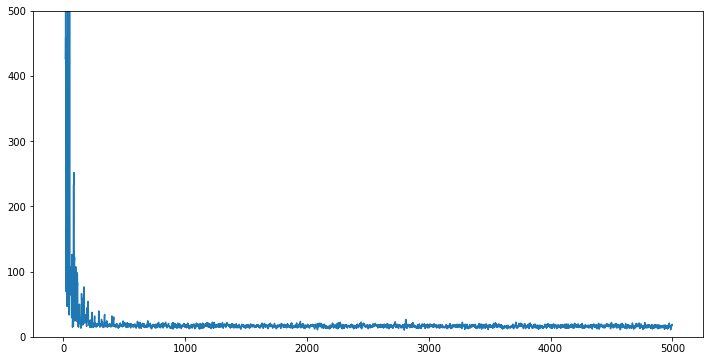

In [9]:
# PLOT TRAJECTORIES LENGTH


lens = []
for t in trajectories:#[:1500]:
    lens.append(len(t))
lens_df = pd.DataFrame(lens)
lens_df['mean_len'] = lens_df[0].rolling(4).mean()

plt.figure(figsize=(12,6))
plt.plot(lens_df['mean_len'])
plt.ylim(0,500)

In [ ]:
# POLICY DEMO
num_eps = 500
env = gym.make("Taxi-v3").env
cur_state = env.reset()
cur_action = env.action_space.sample()

for eps in range(num_eps):
    new_episode = run_episode(env, cur_state, cur_action, policy, state_action_values, show=True)
    print('SUCCESSS!!! '*100)
    start_state = env.reset()

SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCCESSS!!! SUCC

False